## Setting Up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
from pandas.tseries.offsets import MonthEnd
import hashlib

from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *
from scripts.config_CH import *
from scripts.xgb_helpers import *
from scripts.geodata import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.SwitzerlandConfig()

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'

# Read glacier ids:
glacier_ids = get_glacier_ids()

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    # "aspect", # OGGM
    # "slope", # OGGM
    "aspect_sgi",  # SGI
    "slope_sgi",  # SGI
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
    "millan_v",  # OGGM
]

## Read GL data:

In [3]:
data_glamos = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset_all.csv')

print('Number of glaciers:', len(data_glamos['GLACIER'].unique()))
print('Number of winter and annual samples:', len(data_glamos))
print('Number of annual samples:',
      len(data_glamos[data_glamos.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_glamos[data_glamos.PERIOD == 'winter']))

# Capitalize glacier names:
glacierCap = {}
for gl in data_glamos['GLACIER'].unique():
    if isinstance(gl, str):  # Ensure the glacier name is a string
        if gl.lower() == 'claridenu':
            glacierCap[gl] = 'Clariden_U'
        elif gl.lower() == 'claridenl':
            glacierCap[gl] = 'Clariden_L'
        else:
            glacierCap[gl] = gl.capitalize()
    else:
        print(f"Warning: Non-string glacier name encountered: {gl}")

data_glamos.head(2)

Number of glaciers: 31
Number of winter and annual samples: 31875
Number of annual samples: 7587
Number of winter samples: 24288


,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,RGIId,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v,aspect_sgi,slope_sgi,topo_sgi
0,2006,adler_28,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2.592,annual,RGI60-11.02764,254.483669,19.483581,3039.0,-1.504815,43.181839,3.591626,286.843880,20.604390,3018.033333
1,2006,adler_54,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2.502,annual,RGI60-11.02764,273.466595,12.549861,3091.0,-0.970061,41.090096,0.975349,258.181463,12.582387,3077.711111


### Glaciers with pot. radiadation data:

In [4]:
# Glaciers with data of potential clear sky radiation
# Format to same names as stakes:
glDirect = np.sort([
    re.search(r'xr_direct_(.*?)\.nc', f).group(1)
    for f in os.listdir(path_pcsr + 'csv/')
])

restgl = np.sort(Diff(list(glDirect), list(data_glamos.GLACIER.unique())))

print('Glaciers with potential clear sky radiation data:\n', glDirect)
print('Number of glaciers:', len(glDirect))
print('Glaciers without potential clear sky radiation data:\n', restgl)

# Filter out glaciers without data:
data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]

# Look at the data of the ERA5 dataset:
xr.open_dataset(path_ERA5_raw + 'era5_monthly_averaged_data.nc')

Glaciers with potential clear sky radiation data:
 ['adler' 'albigna' 'aletsch' 'allalin' 'arolla' 'basodino' 'clariden'
 'corbassiere' 'corvatsch' 'findelen' 'forno' 'gietro' 'gorner' 'gries'
 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel' 'oberaar' 'otemma'
 'pers' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna'
 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta' 'taelliboden' 'tortin'
 'tsanfleuron']
Number of glaciers: 34
Glaciers without potential clear sky radiation data:
 ['arolla' 'joeri' 'pers']


<xarray.Dataset> Size: 2GB
Dimensions:    (longitude: 201, latitude: 51, expver: 2, time: 895)
Coordinates:
  * longitude  (longitude) float32 804B 0.0 0.1 0.2 0.3 ... 19.7 19.8 19.9 20.0
  * latitude   (latitude) float32 204B 50.0 49.9 49.8 49.7 ... 45.2 45.1 45.0
  * expver     (expver) int32 8B 1 5
  * time       (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2024-07-01
Data variables: (12/14)
    u10        (time, expver, latitude, longitude) float64 147MB ...
    v10        (time, expver, latitude, longitude) float64 147MB ...
    t2m        (time, expver, latitude, longitude) float64 147MB ...
    fal        (time, expver, latitude, longitude) float64 147MB ...
    snowc      (time, expver, latitude, longitude) float64 147MB ...
    rsn        (time, expver, latitude, longitude) float64 147MB ...
    ...         ...
    smlt       (time, expver, latitude, longitude) float64 147MB ...
    slhf       (time, expver, latitude, longitude) float64 147MB ...
    str        (time, expver, latitude, longitude) float64 147MB ...
    sshf       (time, expver, latitude, longitude) float64 147MB ...
    ssrd       (time, expver, latitude, longitude) float64 147MB ...
    tp         (time, expver, latitude, longitude) float64 147MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-08 11:30:10 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

## Geodetic MB:

In [5]:
def check_geodetic_grids_present(folder_path, glacier_name,
                                 periods_per_glacier):
    """
    Checks if all years between min_start and max_end are present in the folder.

    Parameters:
    - folder_path: Path to the folder containing the files.
    - glacier_name: Name of the glacier to filter relevant files.

    Returns:
    - A set of missing years (if any) and a boolean indicating if all years are present.
    """
    min_start = [min([p[0] for p in periods_per_glacier[glacier_name]])][0]
    max_end = [max([p[1] for p in periods_per_glacier[glacier_name]])][0]

    # Extract list of files related to the given glacier
    files = [
        f for f in os.listdir(folder_path)
        if f.startswith(f"{glacier_name}_grid_") and f.endswith(".parquet")
    ]

    # Extract available years from filenames
    year_pattern = re.compile(rf"{glacier_name}_grid_(\d{{4}})\.parquet")
    available_years = {
        int(year_pattern.search(f).group(1))
        for f in files if year_pattern.search(f)
    }

    # Expected years
    expected_years = set(range(min_start, max_end + 1))

    # Identify missing years
    missing_years = expected_years - available_years
    missing_years = sorted(list(missing_years))

    all_years_present = len(missing_years) == 0
    return missing_years, all_years_present

### Pre-process geodetic MB:

In [6]:
geodetic_mb = get_geodetic_MB()

# filter to glaciers with potential clear sky radiation data
geodetic_mb = geodetic_mb[geodetic_mb.glacier_name.isin(glDirect)]

# get years per glacier
years_start_per_gl = geodetic_mb.groupby(
    'glacier_name')['Astart'].unique().apply(list).to_dict()
years_end_per_gl = geodetic_mb.groupby('glacier_name')['Aend'].unique().apply(
    list).to_dict()

periods_per_glacier = defaultdict(list)
geoMB_per_glacier = defaultdict(list)

# Iterate through the DataFrame rows
for _, row in geodetic_mb.iterrows():
    glacier_name = row['glacier_name']
    start_year = row['Astart']
    end_year = row['Aend']
    geoMB = row['Bgeod']

    # Append the (start, end) tuple to the glacier's list
    # Only if period is longer than 5 years
    if end_year - start_year >= 5:
        periods_per_glacier[glacier_name].append((start_year, end_year))
        geoMB_per_glacier[glacier_name].append(geoMB)

# sort by glacier_list
periods_per_glacier = dict(sorted(periods_per_glacier.items()))
geoMB_per_glacier = dict(sorted(geoMB_per_glacier.items()))

### Get glacier list:

In [7]:
glacier_list = [f for f in list(periods_per_glacier.keys())]

# Sort glaciers by area
gl_area = get_gl_area()
gl_area['clariden'] = gl_area['claridenL']


# Sort the lists by area if available in gl_area
def sort_by_area(glacier_list, gl_area):
    return sorted(glacier_list, key=lambda g: gl_area.get(g, 0), reverse=False)


glacier_list = sort_by_area(glacier_list, gl_area)
# print len and list
print('Number of glaciers:', len(glacier_list))
print('Glaciers:', glacier_list)

Number of glaciers: 30
Glaciers: ['schwarzbach', 'taelliboden', 'sanktanna', 'corvatsch', 'sexrouge', 'murtel', 'plattalva', 'tortin', 'basodino', 'limmern', 'adler', 'hohlaub', 'albigna', 'tsanfleuron', 'silvretta', 'oberaar', 'gries', 'clariden', 'gietro', 'schwarzberg', 'forno', 'plainemorte', 'allalin', 'otemma', 'findelen', 'rhone', 'morteratsch', 'corbassiere', 'gorner', 'aletsch']


### Missing data:

In [8]:
path_xr_masked_grids = '../../../data/GLAMOS/topo/GLAMOS_DEM/xr_masked_grids/'
existing_files = set(
    os.listdir(path_xr_masked_grids))  # Load file list once for efficiency

for glacier_name in glacier_list:
    print(f'{glacier_name.capitalize()}:')

    min_start = min(p[0] for p in periods_per_glacier[glacier_name])
    max_end = max(p[1] for p in periods_per_glacier[glacier_name])

    print(f'Longest geodetic period: {min_start} - {max_end}')
    print(f'Geodetic periods: {periods_per_glacier[glacier_name]}')

    # Geodetic MB:
    missing_years, all_years_present = check_geodetic_grids_present(
        os.path.join(path_glacier_grid_glamos, glacier_name), glacier_name,
        periods_per_glacier)
    if not all_years_present:
        print(f'Missing DEMS geodetic MB: {missing_years}')

    # Gridded MB:
    print('...')
    GLAMOS_glwmb = get_GLAMOS_glwmb(glacier_name)
    if GLAMOS_glwmb is None:
        print('-------------------------------')
        continue

    start = max(GLAMOS_glwmb.index.min(), 1951)
    end = GLAMOS_glwmb.index.max()

    print(f'Gridded MB period: {start} - {end}')

    # Check that each year in the range has an xr_masked_grids
    missing_years = [
        year for year in range(start, end + 1)
        if year >= 1951 and f'{glacier_name}_{year}.zarr' not in existing_files
    ]

    if missing_years:
        print(f'Missing DEMS gridded MB: {missing_years}')

    print('-------------------------------')

Schwarzbach:
Longest geodetic period: 2010 - 2021
Geodetic periods: [(2010, 2016), (2010, 2021), (2016, 2021)]
Missing DEMS geodetic MB: [2010, 2011, 2012]
...
Gridded MB period: 2013 - 2021
-------------------------------
Taelliboden:
Longest geodetic period: 2015 - 2023
Geodetic periods: [(2015, 2023), (2017, 2023)]
Missing DEMS geodetic MB: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
...
Gridded MB period: 1956 - 1996
-------------------------------
Sanktanna:
Longest geodetic period: 2010 - 2021
Geodetic periods: [(2010, 2016), (2010, 2021), (2016, 2021)]
Missing DEMS geodetic MB: [2010, 2011]
...
Gridded MB period: 2012 - 2023
-------------------------------
Corvatsch:
Longest geodetic period: 2015 - 2022
Geodetic periods: [(2015, 2022)]
Missing DEMS geodetic MB: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
...
Gridded MB period: 2013 - 2022
Missing DEMS gridded MB: [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
-------------------------------
Sexrouge

In [9]:
geodetic_mb[geodetic_mb.glacier_name == 'corvatsch']['SGI-ID']

5927    E23-18
Name: SGI-ID, dtype: object

# One glacier example: Gries

## Stake data:
### Input dataset:

In [10]:
glacier_name = 'gries'

data_gl = data_glamos[data_glamos.GLACIER == glacier_name]

min_start = min(p[0] for p in periods_per_glacier[glacier_name])
max_end = max(p[1] for p in periods_per_glacier[glacier_name])

print(f'Longest geodetic period: {min_start} - {max_end}')
print(f'Geodetic periods: {periods_per_glacier[glacier_name]}')

# Geodetic MB:
missing_years, all_years_present = check_geodetic_grids_present(
    os.path.join(path_glacier_grid_glamos, glacier_name), glacier_name,
    periods_per_glacier)
if not all_years_present:
    print(f'Missing DEMS geodetic MB: {missing_years}')

# Gridded MB:
print('...')
GLAMOS_glwmb = get_GLAMOS_glwmb(glacier_name)

start = max(GLAMOS_glwmb.index.min(), 1951)
end = GLAMOS_glwmb.index.max()

print(f'Gridded MB period: {start} - {end}')

# Check that each year in the range has an xr_masked_grids
missing_years = [
    year for year in range(start, end + 1)
    if year >= 1951 and f'{glacier_name}_{year}.zarr' not in existing_files
]

if missing_years:
    print(f'Missing DEMS gridded MB: {missing_years}')

Longest geodetic period: 2007 - 2022
Geodetic periods: [(2007, 2012), (2007, 2013), (2007, 2014), (2007, 2015), (2007, 2016), (2007, 2017), (2007, 2018), (2007, 2019), (2007, 2020), (2007, 2021), (2007, 2022), (2012, 2017), (2012, 2018), (2012, 2019), (2012, 2020), (2012, 2021), (2012, 2022), (2013, 2018), (2013, 2019), (2013, 2020), (2013, 2021), (2013, 2022), (2014, 2019), (2014, 2020), (2014, 2021), (2014, 2022), (2015, 2020), (2015, 2021), (2015, 2022), (2016, 2021), (2016, 2022), (2017, 2022)]
...
Gridded MB period: 1962 - 2023


In [11]:
# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': path_PMB_GLAMOS_csv,
    'era5_climate_data': path_ERA5_raw + 'era5_monthly_averaged_data.nc',
    'geopotential_data': path_ERA5_raw + 'era5_geopotential_pressure.nc',
    'radiation_save_path': path_pcsr + 'csv/'
}
RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     data_glamos=data_gl,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file='CH_wgms_dataset_gries.csv')

data_monthly = dataloader_gl.data


# Generate a unique glacier-wide ID
def get_hash(unique_string):
    unique_id = hashlib.md5(
        unique_string.encode()).hexdigest()[:10]  # Shortened hash
    return unique_id


data_monthly['GLWD_ID'] = data_monthly.apply(
    lambda x: get_hash(f"{x.GLACIER}_{x.YEAR}"), axis=1)

data_monthly['GLWD_ID'] = data_monthly['GLWD_ID'].astype(str)

dataloader_gl = mbm.DataLoader(cfg,
                               data=data_monthly,
                               random_seed=cfg.seed,
                               meta_data_columns=cfg.metaData)
data_monthly = dataloader_gl.data

2025-03-20 08:25:15,988 - INFO - Loaded preprocessed data.
2025-03-20 08:25:15,989 - INFO - Number of monthly rows: 25645
2025-03-20 08:25:15,993 - INFO - Number of annual rows: 16411
2025-03-20 08:25:15,997 - INFO - Number of winter rows: 9234


In [12]:
data_monthly.columns

Index(['YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE', 'ALTITUDE_CLIMATE',
       'ELEVATION_DIFFERENCE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
       'N_MONTHS', 'MONTHS', 'PERIOD', 'GLACIER', 'aspect_sgi', 'slope_sgi',
       'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp',
       'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'pcsr', 'GLWD_ID'],
      dtype='object')

### Blocking on stakes:

Train:
Number of winter and annual samples: 23104
Number of annual samples: 14843
Number of winter samples: 8261
Test:
Number of winter and annual samples: 2541
Number of annual samples: 1568
Number of winter samples: 973
Total:
Number of monthly rows: 25645
Number of annual rows: 16411
Number of winter rows: 9234


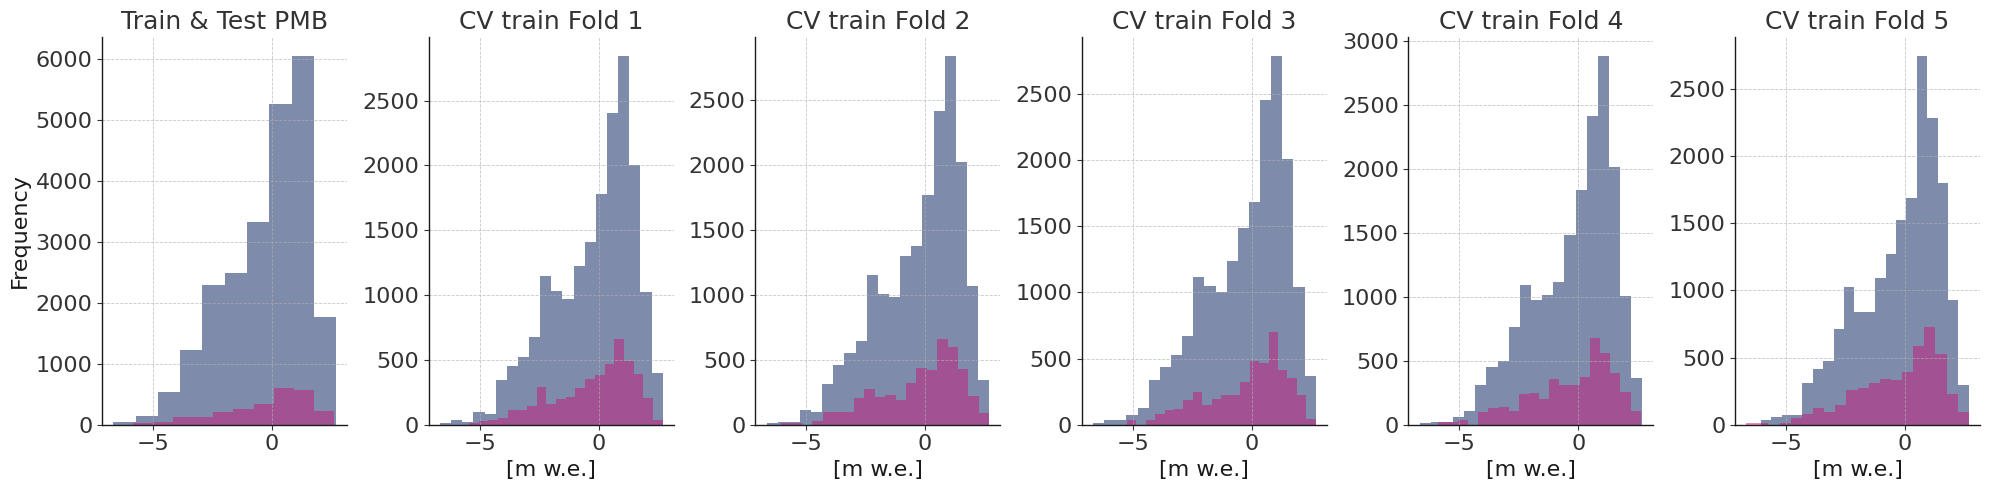

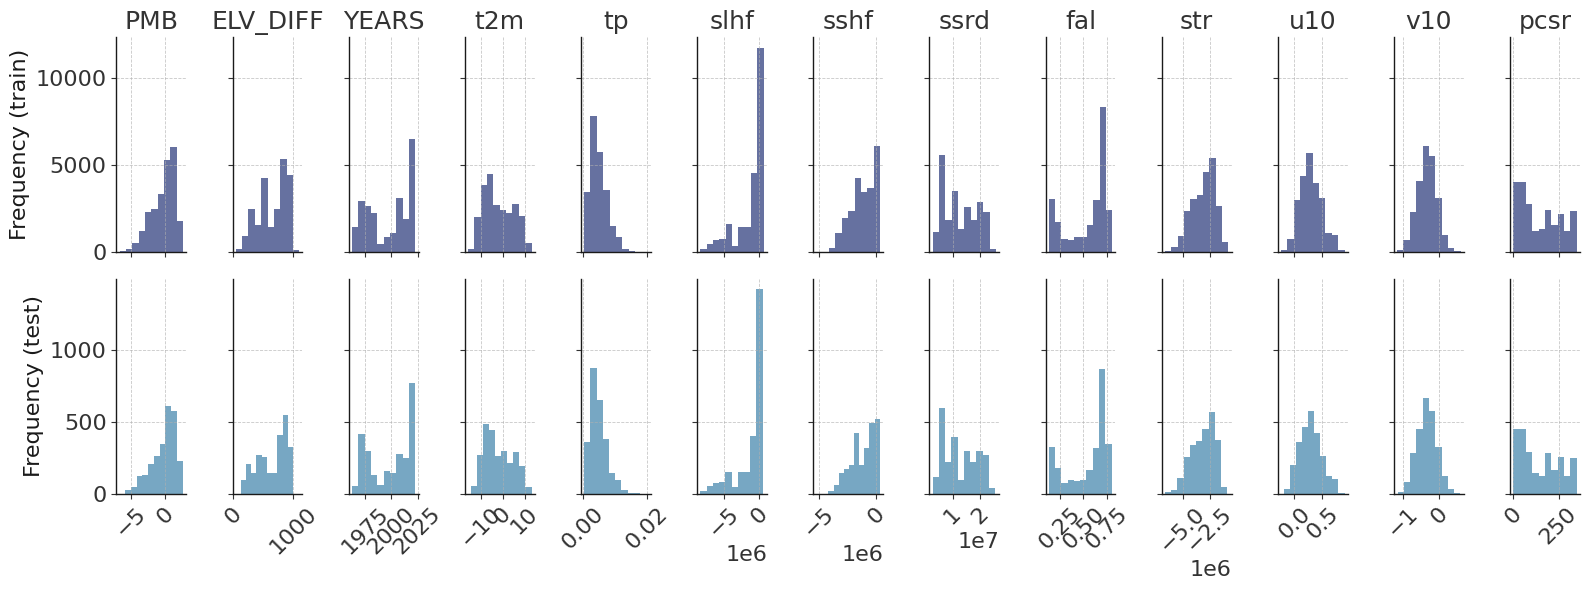

In [13]:
# Split on measurements (IDs)
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='ID',
                                            random_state=cfg.seed,
                                            test_size=0.1)

# Check that no ID from train set is in test set
assert len(set(train_set['df_X'].ID).intersection(set(
    test_set['df_X'].ID))) == 0

data_train = train_set['df_X']
data_test = test_set['df_X']

# Number of annual versus winter measurements:
print('Train:')
print('Number of winter and annual samples:', len(data_train))
print('Number of annual samples:',
      len(data_train[data_train.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_train[data_train.PERIOD == 'winter']))

# Same for test
data_test_annual = data_test[data_test.PERIOD == 'annual']
data_test_winter = data_test[data_test.PERIOD == 'winter']

print('Test:')
print('Number of winter and annual samples:', len(data_test))
print('Number of annual samples:', len(data_test_annual))
print('Number of winter samples:', len(data_test_winter))

print('Total:')
print('Number of monthly rows:', len(dataloader_gl.data))
print('Number of annual rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
print('Number of winter rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))

visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

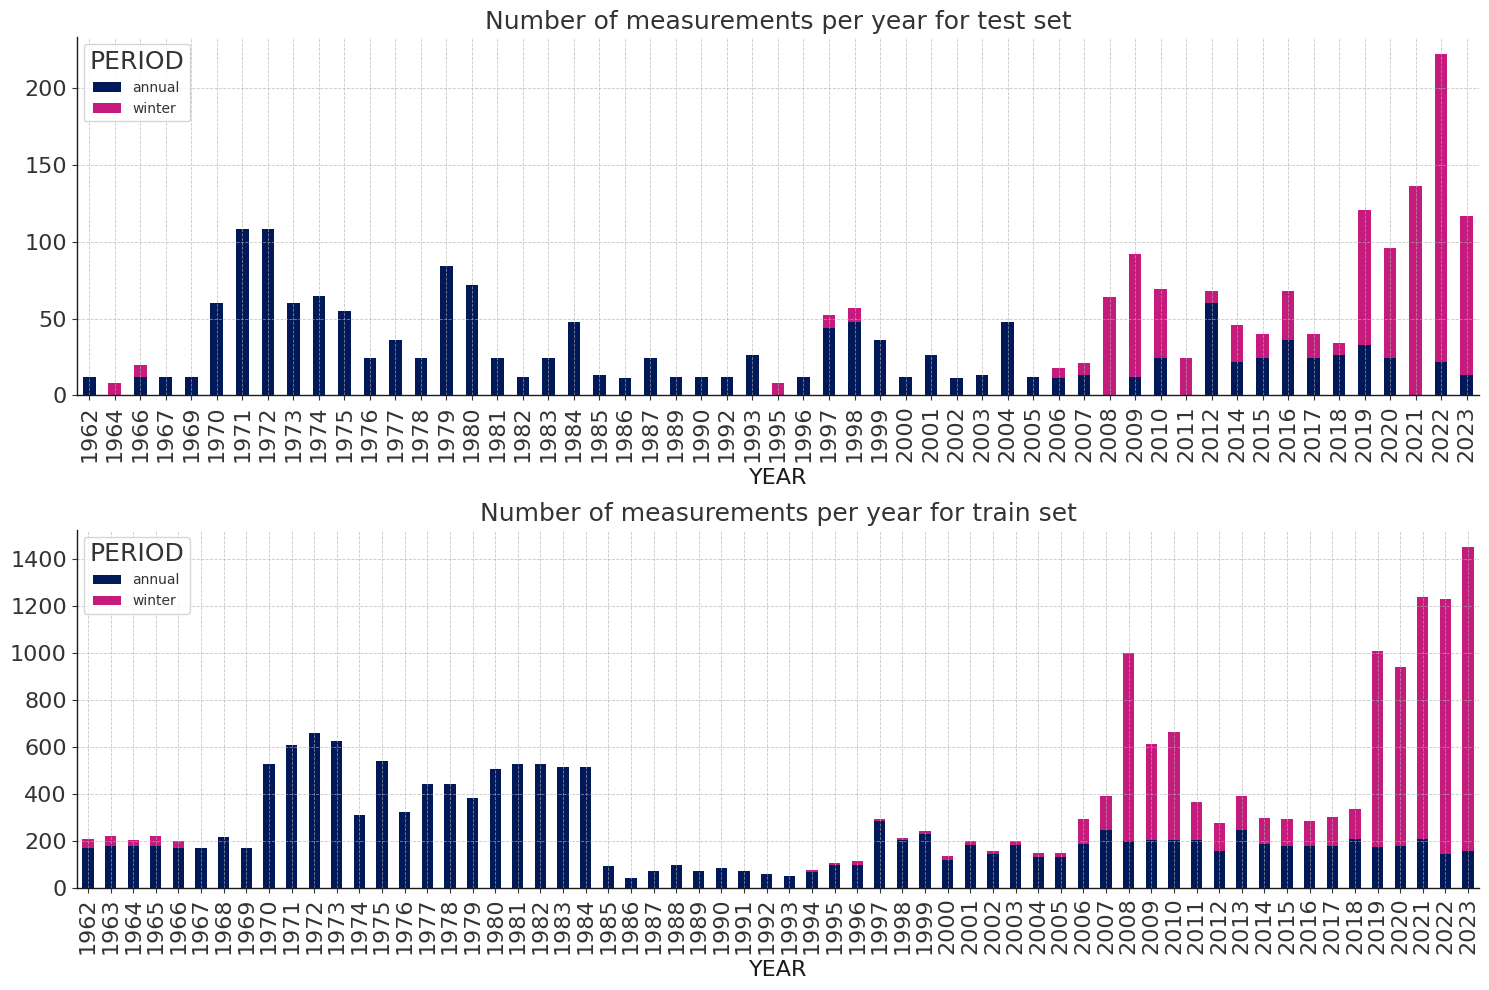

In [14]:
# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
data_test.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test set')

# Number of measurements per year:
data_train.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train set')
plt.tight_layout()

## XGBoost:

In [15]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect_sgi",
    "slope_sgi",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

### Predictions of custom parameters:

Shape of training dataset: (23104, 28)
Shape of testing dataset: (2541, 28)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect_sgi', 'slope_sgi', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 'pcsr']
{'device': 'cuda:0', 'tree_method': 'hist', 'random_state': 30, 'n_jobs': -1, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}
Shape of the test: (2541, 16)
Overall score: 0.1524634370664211
{'gries': '#a6cee3'}


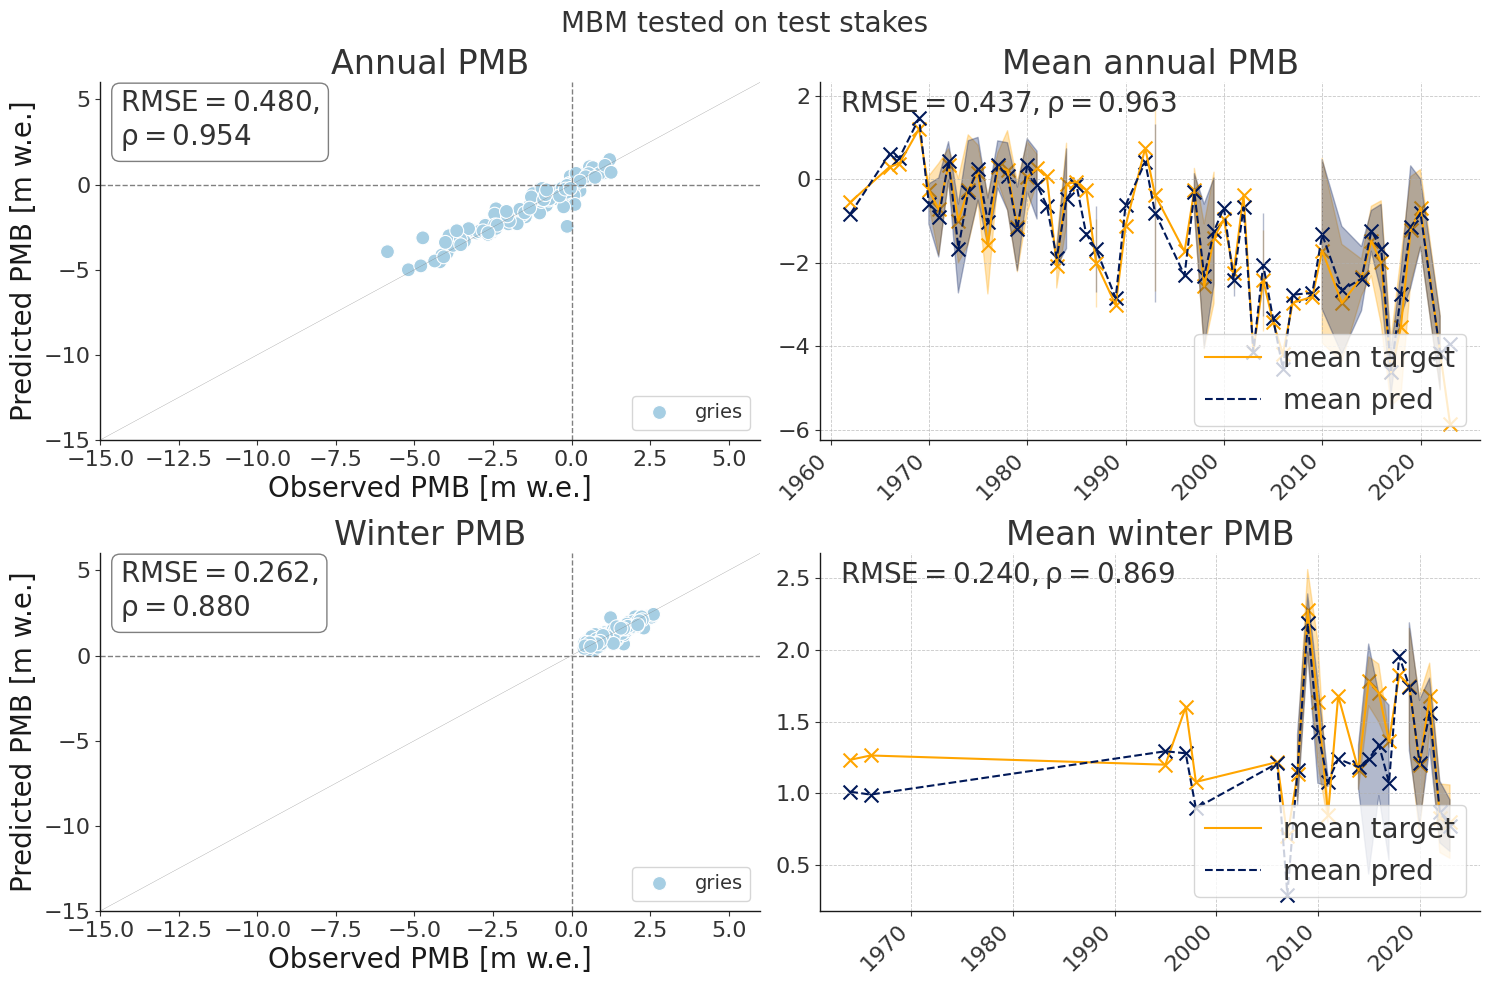

In [16]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(cfg, **params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'MBM tested on test stakes', fontsize=20)
plt.tight_layout()

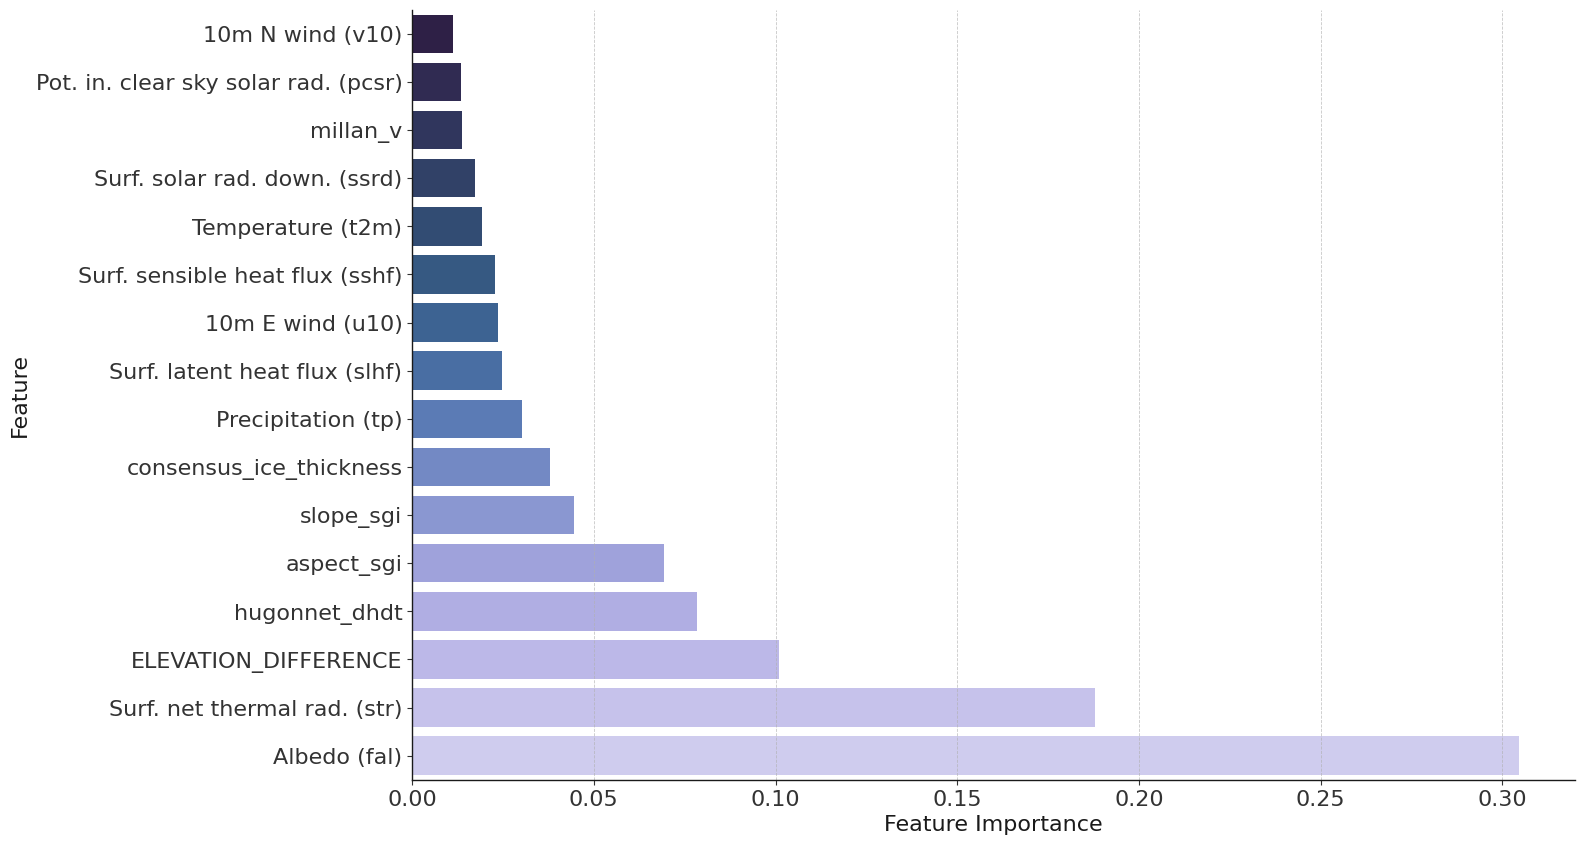

In [17]:
FIPlot(custom_model, feature_columns, vois_climate)

## One geodetic period:

In [18]:
glacier_name = 'gries'

geodetic_period = periods_per_glacier[glacier_name][0]
geodetic_range = range(geodetic_period[0], geodetic_period[1] + 1)
folder_path = os.path.join(path_glacier_grid_glamos, glacier_name)

# check that parquet files for each year
files = [
    f for f in os.listdir(folder_path)
    if f.startswith(f"{glacier_name}_grid_") and f.endswith(".parquet")
]

# Extract available years from filenames
year_pattern = re.compile(rf"{glacier_name}_grid_(\d{{4}})\.parquet")
available_years = {
    int(year_pattern.search(f).group(1))
    for f in files if year_pattern.search(f)
}

# check that period overlaps with available years
assert (len(set(available_years).intersection(
    set(geodetic_range))) == len(geodetic_range))

In [19]:
def create_geodetic_input(glacier_name, periods_per_glacier):
    """
    Creates a geodetic input array for MBM for a given glacier.
    
    Parameters:
    - glacier_name (str): Name of the glacier.
    - path_glacier_grid_glamos (str): Path to the glacier grid files.
    - periods_per_glacier (dict): Dictionary mapping glacier names to year ranges.
    - all_columns (list): List of required columns.

    Returns:
    - pd.DataFrame: Processed geodetic input dataframe.
    """

    # Get the minimum and maximum geodetic years for the glacier
    min_geod_y, max_geod_y = np.min(periods_per_glacier[glacier_name]), np.max(
        periods_per_glacier[glacier_name])

    df_X_geod = pd.DataFrame()

    for year in range(min_geod_y, max_geod_y + 1):
        file_name = f"{glacier_name}_grid_{year}.parquet"
        file_path = os.path.join(path_glacier_grid_glamos, glacier_name,
                                 file_name)

        if not os.path.exists(file_path):
            print(f"Warning: File {file_name} not found, skipping...")
            continue

        # Load parquet input glacier grid file in monthly format (pre-processed)
        df_grid_monthly = pd.read_parquet(file_path)
        df_grid_monthly.drop_duplicates(inplace=True)

        # Add GLWD_ID (unique glacier-wide ID for the year)
        df_grid_monthly['GLWD_ID'] = get_hash(f"{glacier_name}_{year}")

        # Generate a unique ID per year by modifying the existing ID
        if 'ID' in df_grid_monthly.columns:
            df_grid_monthly['ID'] = df_grid_monthly.apply(
                lambda x: get_hash(f"{x.ID}_{x.YEAR}"), axis=1)
        else:
            print(
                f"Warning: 'ID' column missing in {file_name}, skipping ID modification."
            )

        # Append to the final dataframe
        df_X_geod = pd.concat([df_X_geod, df_grid_monthly], ignore_index=True)

    return df_X_geod

In [20]:
# Create geodetic input array for MBM for one glacier:
df_X_geod = create_geodetic_input(glacier_name, periods_per_glacier)
df_X_geod.head(2)

,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,tp,slhf,sshf,ssrd,fal,str,u10,v10,pcsr,GLWD_ID
0,2007,8.316049,46.424695,0,2181.993802,953.466198,3135.46,RGI60-11.01876,1,b096ff65fd,...,0.003813,-4.269774e+06,-2.725862e+06,1.540485e+07,0.248690,-4.920937e+06,0.330339,-0.484881,199.816467,030f73c6a1
1,2007,8.316049,46.424695,0,2181.993802,953.466198,3135.46,RGI60-11.01876,1,b096ff65fd,...,0.004009,-2.684900e+06,-1.511832e+06,1.004886e+07,0.162399,-4.186864e+06,0.057350,0.105726,100.808032,030f73c6a1


In [ ]:
custom_model.fit(df_X_geod[all_columns], geoMB_per_glacier[glacier_name])

In [24]:
# Apply MBM to the geodetic data:
geoData = mbm.GeoData(df_X_geod)

# Compute cumulative SMB predictions
df_grid_monthly = custom_model.cumulative_pred(geoData.data[all_columns])

# Generate annual and winter predictions
pred_annual = custom_model.glacier_wide_pred(df_grid_monthly[all_columns])
pred_annual.reset_index(inplace=True)
pred_annual.sort_values(by='YEAR', inplace=True)

# check that each GLWD_ID has a unique YEAR
assert pred_annual.groupby(
    'GLWD_ID').YEAR.nunique().value_counts().values == len(
        range(df_X_geod.YEAR.min(),
              df_X_geod.YEAR.max() + 1))

# Calculate mean SMB per year and store in a DataFrame
mean_SMB = pred_annual.groupby('GLWD_ID').agg({
    'pred':
    'mean',
    'YEAR':
    lambda x: x.unique().item()
})
mean_SMB = mean_SMB.sort_values(by='YEAR').reset_index().set_index('YEAR')

# Calculate the geodetic mb for each range
geodetic_MB_pred, geodetic_MB_target = [], []
for geodetic_period in periods_per_glacier[glacier_name]:
    geodetic_range = range(geodetic_period[0], geodetic_period[1] + 1)
    geodetic_MB_pred.append(mean_SMB.loc[geodetic_range].pred.mean())

    geodetic_MB_target.append(
        geodetic_mb[(geodetic_mb.glacier_name == glacier_name)
                    & (geodetic_mb.Astart == geodetic_period[0])
                    &
                    (geodetic_mb.Aend == geodetic_period[1])].Bgeod.values[0])

Text(0, 0.5, 'MBM prediction')

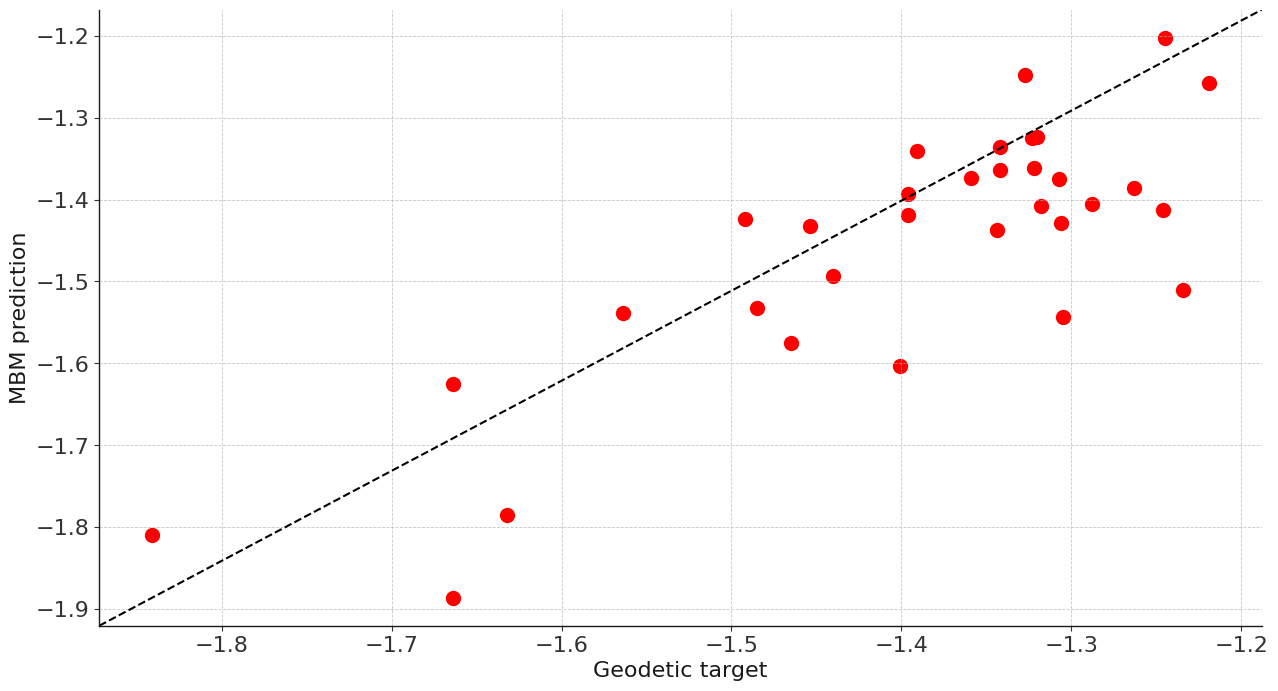

In [23]:
# Scatter target and predicted geodet
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(geodetic_MB_target,
           geodetic_MB_pred,
           color='red',
           label='Geodetic MB')

# Add identity line
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', linestyle='--')

# set labels
ax.set_xlabel('Geodetic target')
ax.set_ylabel('MBM prediction')

In [ ]:
# Plot both the prediction and the target
fig, ax = plt.subplots(figsize=(15, 8))
mean_SMB.pred.plot(ax=ax, label='MBM prediction')
# set title
ax.set_title(f'MBM surface MB prediction for {glacier_name.capitalize()}')

In [ ]:
# # open xarray
# # plot all years
# fig, axs = plt.subplots(1, len(geodetic_range), figsize=(20, 5), sharey=True)
# for year in geodetic_range:
#     xr.open_dataset(path_save_glw +
#                     f'{glacier_name}/{glacier_name}_{year}_annual.zarr'
#                     ).pred_masked.plot(ax=axs[year - geodetic_range[0]])
#     axs[year - geodetic_range[0]].set_title(f'{year}')

# plt.tight_layout()